# Variational circuits for a classification problem

This notebook is an illustration on how variational quantum circuits can be used for solving machine learning problems. In this case, we will take the example of a binary classification problem.

### What is a variational circuit ?

In the general case, a variational method is the approximation of an intractable function $f$ (for example solution of a PDE or an optimization problem) by a function $v$, more easily computable. The goal is then to find $v$ that will minimize a specific cost $\mathcal{L}(v)$. The cost function may be expensive to compute, which makes the problem difficult to solve. The idea of using Quantum Computing is to reduce the cost of estimation and in some cases gain an advantage on classical computers.

In our Machine Learning problem, let us suppose we observe $N$ samples of labeled data $(x_i, y_i)_{i \in [1,N]}$ with $x_i \in \mathbb{R}^2$ and $y_i \in \{0,1\}$. The goal of the task is to construct a predictor $f$ to estimate $y$ given a new value of $x$. The problem can be restricted to a set of parameterizable functions by a real vector $\theta$. We will train a model with the training input by finding the parameters $\theta$ that will minimize a loss $l$.

$$\arg\min_{\theta} \frac{1}{N} \sum_{i=1}^{N} l(f(x_i;\theta), y_i)$$

In our case, $f$ will return the probability of $x$ to be labelled $1$. It is then a number comprised between 0 and 1.
The authors use the square loss $l(f(x),y) = (f(x)-y)^2$, another usual loss is the binary crossentropy loss $l(f(x),y) = - y log(f(x)) - (1-y)log(1-f(x))$. In both cases, the farther $f(x)$ is from $y$, the greater the loss.

### The use of quantum computers

The idea of the proposed circuit is to compute $f(x;\theta)$ with a quantum computer, and then to optimize the cost with a classical optimization algorithm, with the hope that it will be more efficient than a full classical algorithm.

Quantum circuits are a very good framework to represent our problem, since the probability of a qubit to be in the state $|0\rangle$ or in the state $|1\rangle$ can be estimated by measurement. 

The circuit is composed of 3 steps: 

- State preparation: encode the classical data $x$ into a quantum circuit buy creating an operator $\phi(x)$ which will result in the state $\phi(x) |0_p\rangle$ with $p$ the number of qubits.
- Model circuit: apply an operator $U(\theta)$ to the feature state, with $\theta$ the trainable parameters.
- Measurement: measure the qubit $q_0$ to estimate $f(x;\theta) = \mathbb{P}(q_0=1)$

### State preparation

The classical data need to be converted into a quantum state. A quantum state is a unitary norm vector of complex numbers and can be written $|\psi \rangle = \sum_{i=1}^{n} a_i |i\rangle$ with $\sum_{i=1}^{n} |a_i|^2=1$, and $n=2^p$. Vectors with a power of 2 number of features can be normalized and represented into a quantum state using amplitude encoding, which means that the data are directly associated with the amplitudes of the quantum state. For other number of features, a strategy is to pad with the required number of features to reach a power of 2. The padding features can be zero on non-zero. It can be shown that the encoding can be done linearly with reference to the size of the input vector.

### Model circuit

Given the quantum state $|\phi(x) \rangle$ which represents the vector $x$ in the quantum circuit, we create $U(\theta)$ a unitary operator such that $U(\theta)|\phi(x) \rangle$ is a quantum state we can measure. 

We decompose $U(\theta) = U_1...U_L$ as a product of one or two qubits parametrized gates. In the following we will use a combination of C-NOT gates and general unitary gates whose general formulation is:
$$U(\theta, \phi, \lambda) = \begin{bmatrix}
  cos(\frac{\theta}{2}) & -e^{i\lambda}sin(\frac{\theta}{2})\\ 
  e^{i\phi}sin(\frac{\theta}{2}) & e^{i\lambda+i\phi}cos(\frac{\theta}{2})
\end{bmatrix} 
$$


### Measurement

The measurement of the 0 qubit of the quantum state $|U(\theta)\phi(x) \rangle$ generated by the previous circuit gives $f(x;\theta) = \mathbb{P}(y|x=1;\theta) = \mathbb{P}(q_0=1|x;\theta) = \sum_{k=1}^{n} |(U(\theta)\phi(x))_k|^2$. For clarity, the explicit dependency of $\theta$ will be removed and we will just note $U$ for $U(\theta)$

Let us denote $\pi(x;\theta) = \mathbb{P}(q_0=1|x;\theta)$. It can also be expressed by the expectancy of the operator $\sigma_z$ applied to the first qubit. $$\mathbb{E}(\sigma_z) = \langle \phi(x)|U^\dagger (\sigma_z \otimes \mathbb{I} \otimes ... \otimes \mathbb{I})U|\phi(x) \rangle$$ and $$\pi(x;\theta) = \frac{-\mathbb{E}(\sigma_z)}{2}+\frac{1}{2}$$.



### Training

The model is trained to minimize a loss function
$$\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^{N} l(\pi(x_i;\theta), y_i)$$
The parameters are updated via batch stochastic gradient descent. The difficulty is to be able to compute the gradient in an accurate way. Fortunately, as later explained it is possible to evaluate the gradient via quantum circuits.

$$\nabla_\theta\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^{N} \nabla_\theta(l(\pi(x_i;\theta), y_i)) = 
\frac{1}{N} \sum_{i=1}^{N} \nabla_\theta\pi(x_i;\theta)\partial_1l(\pi(x_i;\theta), y_i)$$ where $\partial_1l$ is the partial derivative of $l$ with reference to the first variable.

$$\nabla_\theta\pi(x_i;\theta) = \frac{-\nabla_\theta\mathbb{E}(\sigma_z)}{2} = -\frac{1}{2} \nabla_\theta\langle \phi(x)U | \sigma_z U|\phi(x) \rangle$$ where $\sigma_z \otimes \mathbb{I} \otimes ... \otimes \mathbb{I}$ is abbreviated to $\sigma_z$.

Let us now consider $\nu$ an element of the vector $\theta$ and let us examine $\partial_\nu \pi(x;\theta)$

$$\partial_\nu\pi(x;\theta) = -\frac{1}{2} \langle \phi(x)\partial_\nu U| \sigma_z |U\phi(x) \rangle -\frac{1}{2} \langle \phi(x)U |\sigma_z |\partial_\nu U\phi(x) \rangle $$ by the rules of derivation inside an expactancy. 

$$\partial_\nu\pi(x;\theta) = -\frac{1}{2} (\langle \phi(x)\partial_\nu U| \sigma_z U|\phi(x) \rangle + \langle \phi(x)\partial_\nu U| \sigma_z |U\phi(x) \rangle^*) = - Re\{ \langle \phi(x)\partial_\nu U| \sigma_z |U\phi(x) \rangle\}$$

Generally speaking, $\partial_\nu U$ is not a unitary operator, and therefore cannot be implemented in a quantum circuit. However, due to our circuit architecture, il will be possible.

The derivative of $U$ w.r.t $\nu$ involves only the derivative of the elementary gate to which $\nu$ belongs, due to the factorization of the circuit. It means that $\partial_\nu U = U_1...\partial_\nu(U_i)...U_L$ where $U_i$ is the gate to which $\nu$ belongs.

For an elementary unitary gate as described above, we have the following identities:

$$\partial_\theta U = \frac{1}{2} U(\theta + \pi, \phi, \lambda)$$

$$\partial_\phi U = \frac{i}{2} (U(\theta, \phi, \lambda) - U(\theta, \phi + \pi, \lambda))$$

$$\partial_\lambda U = \frac{i}{2} U(\theta, \phi, \lambda) - U(\theta, \phi, \lambda + \pi))$$

Therefore $\partial_\nu U$ can be computed as the form

$$ \sum_{k=1}^{K}a_k Re\{ \langle \phi(x)U(\theta^{[k]})| \sigma_z |U(\theta)\phi(x) \rangle\}+ \sum_{l=1}^{L}b_l Im\{ \langle \phi(x)U(\theta^{[l]})| \sigma_z |U(\theta)\phi(x) \rangle\}$$ where $\theta^{[k]}$ and $\theta^{[l]}$ are the modified vector of parameters from the above identities. The imaginary part comes from the $i$ in the same identities for $\phi$ and $\lambda$

In [1]:
import numpy as np
from qiskit import *
from qiskit.tools.jupyter import *
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.preprocessing import Normalizer

backend = BasicAer.get_backend('qasm_simulator')


In [2]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1]) ** 2 / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3]) ** 2 / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

In [3]:
data = np.loadtxt("iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print("First X sample (original)  :", X[0])

# pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm])
print("First features sample      :", features[0])

Y = (data[:, -1] + 1) / 2

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.3  0.  ]
First X sample (normalized): [0.44376016 0.83205029 0.33282012 0.        ]
First features sample      : [ 0.67858523 -0.          0.         -1.080839    1.080839  ]


In [4]:
def statepreparation(a, circuit, target):
    
    a = 2*a
    circuit.ry(a[0], target[0])
    
    circuit.cx(target[0], target[1])
    circuit.ry(a[1], target[1])
    circuit.cx(target[0], target[1])
    circuit.ry(a[2], target[1])

    circuit.x(target[0])
    circuit.cx(target[0], target[1])
    circuit.ry(a[3], target[1])
    circuit.cx(target[0], target[1])
    circuit.ry(a[4], target[1])
    circuit.x(target[0])
    
    return circuit

In [5]:
def u_gate(param, circuit, target):
    '''Return the quantum circuit with u3 gate applied on qubit target with param as an iterable'''
    circuit.u3(param[0],param[1],param[2],target)
    return circuit

def cu_gate(param, circuit, control, target):
    '''Return the quantum circuit with cu3 gate applied on qubit target with param as an iterable wrt control'''
    circuit.cu3(param[0],param[1],param[2], control, target)
    return circuit

def circuit_block(param, circuit, target, same_order_x=True):
    '''Return the block applied on qubits target from the circuit circuit
    - param : array parameters for the two u gate
    - target : array of integer the numero of qubits for the u gates to be applied
    - if same_order_x == True : cx(target[0], target[1])
    else: cx(target[1], target[0])'''
    circuit = u_gate(param[0], circuit, target[0])
    circuit = u_gate(param[1], circuit, target[1])
    if same_order_x:
        circuit.cx(target[0], target[1])
    else:
        circuit.cx(target[1], target[0])
    return circuit

def c_circuit_block(param, circuit, control, target, same_order_x=True):
    '''Return the controlled block applied on qubits target from the circuit circuit
    - param : array parameters for the two u gate
    - target : array of integer the numero of qubits for the u gates to be applied
    - if same_order_x == True : cx(target[0], target[1])
    else: cx(target[1], target[0])'''
    circuit = cu_gate(param[0], circuit, control, target[0])
    circuit = cu_gate(param[1], circuit, control, target[1])
    if same_order_x:
        circuit.ccx(control, target[0], target[1])
    else:
        circuit.ccx(control, target[1], target[0])
    return circuit

def create_circuit(param, circuit, target):
    order = True
    for i in range(param.shape[0]):
        circuit = circuit_block(param[i], circuit, target, order)
        order = not order
    return circuit

def create_c_circuit(param, circuit, control, target):
    order = True
    for i in range(param.shape[0]):
        circuit = c_circuit_block(param[i], circuit, control, target, order)
        order = not order 
    return circuit

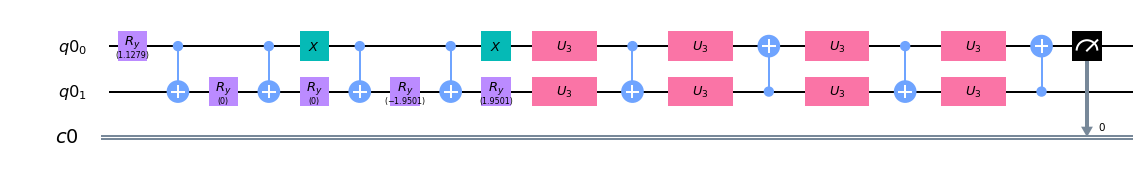

In [6]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0])
ang = get_angles(x)

params = np.array([[[np.pi/3,np.pi/3,np.pi/4],
                    [np.pi/6,np.pi/4,np.pi/6]],
                    [[np.pi/6,np.pi/4,np.pi/4],
                    [np.pi/3,np.pi/7,np.pi/6]],
                    [[np.pi/3,np.pi/3,np.pi/4],
                    [np.pi/6,np.pi/4,np.pi/6]],
                    [[np.pi/6,np.pi/4,np.pi/4],
                    [np.pi/3,np.pi/7,np.pi/6]]])

q       = QuantumRegister(2)
c       = ClassicalRegister(1)
circuit = QuantumCircuit(q,c)
circuit = statepreparation(ang, circuit, [0,1])

circuit = create_circuit(params, circuit, [0,1])

circuit.measure(0,c)

circuit.draw(output='mpl')

In [7]:
def execute_circuit(params, angles=None, x=None, use_angles=True, bias=0, shots=1000):
    if not use_angles:
        angles = get_angles(x)
    q       = QuantumRegister(2)
    c       = ClassicalRegister(1)
    circuit = QuantumCircuit(q,c)
    circuit = statepreparation(angles, circuit, [0,1])

    circuit = create_circuit(params, circuit, [0,1])
    circuit.measure(0,c)
    result = execute(circuit,backend,shots=shots).result()
    #statevector = result.get_statevector(circuit, decimals=3)
    counts = result.get_counts(circuit)
    result=np.zeros(2)
    for key in counts:
        result[int(key,2)]=counts[key]
    result/=shots
    return result[1] + bias

execute_circuit(params, ang, bias=0.02)

0.129

In [14]:
def predict(probas):
    return (probas>=0.5)*1

def binary_crossentropy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss - l * np.log(np.max([p,1e-8]))

    loss = loss / len(labels)
    return loss

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss 

def cost(params, features, labels):
    predictions = [execute_circuit(params, angles=f) for f in features]
    return binary_crossentropy(labels, predictions)

In [15]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [16]:
def real(param1, param2, angles, shots=1000):
    """Returns Re{<circuit(param2)|sigma_z|circuit(param1)>}"""
    q = QuantumRegister(3)
    c = ClassicalRegister(1)
    circuit = QuantumCircuit(q,c)
    circuit.h(q[0])
    circuit = statepreparation(angles, circuit, [1,2])
    circuit = create_c_circuit(param1, circuit, 0, [1,2])
    circuit.cz(q[0], q[1])
    circuit.x(q[0])
    circuit = create_c_circuit(param2, circuit, 0, [1,2])
    circuit.x(q[0])
    circuit.h(q[0])
    circuit.measure(q[0],c)
    result = execute(circuit,backend,shots=shots).result()
    counts = result.get_counts(circuit)
    result=np.zeros(2)
    for key in counts:
        result[int(key,2)]=counts[key]
    result/=shots
    return (2*result[0]-1)

def imaginary(param1, param2, angles, shots=1000):
    """Returns Im{<circuit(param2)|sigma_z|circuit(param1)>}"""
    q = QuantumRegister(3)
    c = ClassicalRegister(1)
    circuit = QuantumCircuit(q,c)
    circuit.h(q[0])
    circuit = statepreparation(angles, circuit, [1,2])
    circuit = create_c_circuit(param1, circuit, 0, [1,2])
    circuit.cz(q[0], q[1])
    circuit.x(q[0])
    circuit = create_c_circuit(param2, circuit, 0, [1,2])
    circuit.x(q[0])
    circuit.u1(np.pi/2, q[0])
    circuit.h(q[0])
    circuit.measure(q[0],c)
    result = execute(circuit,backend,shots=shots).result()
    counts = result.get_counts(circuit)
    result=np.zeros(2)
    for key in counts:
        result[int(key,2)]=counts[key]
    result/=shots
    return -(2*result[0]-1)

In [17]:
def gradients(params, angles, label, bias=0):
    grads = np.zeros_like(params)
    imag = imaginary(params, params, angles)
    for i in range(params.shape[0]):
        for j in range(params.shape[1]):
            params_bis = np.copy(params)
            
            params_bis[i,j,0]+=np.pi
            grads[i,j,0] = -0.5 * real(params, params_bis, angles)
            params_bis[i,j,0]-=np.pi
            
            params_bis[i,j,1]+=np.pi
            grads[i,j,1] = 0.5 * (imaginary(params, params_bis, angles) - imag)
            params_bis[i,j,1]-=np.pi
            
            params_bis[i,j,2]+=np.pi
            grads[i,j,2] = 0.5 * (imaginary(params, params_bis, angles) - imag)
            params_bis[i,j,2]-=np.pi
    p = execute_circuit(params, angles, bias=bias) 
    grad_bias = (p - label) / (p * (1 - p))
    grads *= grad_bias
    return grads, grad_bias
            
    
gradients(params, ang, 1, 0.1)

(array([[[ 0.31 ,  0.905,  1.4  ],
         [-0.175, -0.655, -0.935]],
 
        [[ 0.575,  0.925,  0.795],
         [-0.675,  0.035, -0.595]],
 
        [[-0.46 , -0.24 , -0.905],
         [-1.185,  0.03 ,  0.02 ]],
 
        [[ 0.35 ,  0.305, -0.37 ],
         [ 0.71 ,  0.31 ,  0.82 ]]]), -4.999999999999999)

In [18]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]


In [19]:
layers = 6
params_init = np.random.randn(layers,2,3) * 0.01
bias_init = 0.01
batch_size = 5
learning_rate = 0.01
momentum = 0.9

var = np.copy(params_init)
bias = bias_init
v = np.zeros_like(var)
v_bias = 0

for it in range(20):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    grads = np.zeros_like(var)
    grad_bias = 0
    var_corrected = var + momentum * v
    bias_corrected = bias + momentum * v_bias
    for j in range(batch_size):
        g, g_bias = gradients(var_corrected, feats_train_batch[j], Y_train_batch[j], bias)
        grads += g / batch_size
        grad_bias +=g_bias / batch_size
    
    v = momentum * v - learning_rate * grads
    v_bias = momentum * v_bias - learning_rate * grad_bias
    
    var += v
    bias += v_bias

    # Compute predictions on train and validation set
    probas_train = np.array([execute_circuit(var, angles=f, bias=bias) for f in feats_train])
    probas_val = np.array([execute_circuit(var, angles=f, bias=bias) for f in feats_val])
    predictions_train = predict(probas_train)
    predictions_val = predict(probas_val)

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(var, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 0.4939705 | Acc train: 0.4666667 | Acc validation: 0.3600000 
Iter:     2 | Cost: 0.4775516 | Acc train: 0.4666667 | Acc validation: 0.3600000 
Iter:     3 | Cost: 0.4598722 | Acc train: 0.5066667 | Acc validation: 0.3200000 
Iter:     4 | Cost: 0.4089149 | Acc train: 0.5733333 | Acc validation: 0.4000000 
Iter:     5 | Cost: 0.3730197 | Acc train: 0.6266667 | Acc validation: 0.5200000 
Iter:     6 | Cost: 0.3373007 | Acc train: 0.6533333 | Acc validation: 0.6400000 
Iter:     7 | Cost: 0.2878319 | Acc train: 0.7733333 | Acc validation: 0.7600000 
Iter:     8 | Cost: 0.2473829 | Acc train: 0.8400000 | Acc validation: 0.8000000 
Iter:     9 | Cost: 0.2102287 | Acc train: 0.9066667 | Acc validation: 0.9200000 
Iter:    10 | Cost: 0.1846681 | Acc train: 0.9466667 | Acc validation: 0.9200000 
Iter:    11 | Cost: 0.1586124 | Acc train: 0.9733333 | Acc validation: 0.9600000 
Iter:    12 | Cost: 0.1426971 | Acc train: 0.9866667 | Acc validation: 1.0000000 
Iter:    13 | Co

In [ ]:
probas_train

In [ ]:
Y_train

In [ ]:
var_pen = np.array([[[-1.70008964e-02, -2.84443569e-01,  5.92116445e-03],
         [-7.37017052e-03,  2.07136141e-01,  1.50235744e-02]],
 
        [[-1.60361139e-02,  4.33210544e-01,  7.49550023e-03],
         [-1.54227671e-02,  7.67908247e-01, -3.72027707e-04]],
 
        [[ 3.52989403e-05, -6.48823799e-01, -7.57998915e-03],
         [ 5.74978409e-03,  1.44239487e-01, -8.98559513e-03]],
 
        [[-1.30805347e-02,  3.95215103e-01,  7.98841245e-03],
         [-1.56025301e-02,  3.48950036e-01,  5.27807214e-03]],
 
        [[ 1.74935340e-02, -7.45943116e-01,  1.52679155e-02],
         [ 1.77082265e-02,  6.74894453e-02,  3.06198935e-02]],
 
        [[ 2.14797558e-02,  3.75524005e-01, -1.29316820e-03],
         [-8.98539413e-03,  1.93064772e-02,  1.98606513e-03]]])

//anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


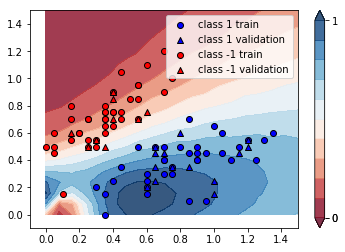

In [14]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [execute_circuit(var, angles=f, bias=bias, shots=10000) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(xx, yy, Z, levels=np.arange(0, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[0, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == 0],
    X_train[:, 1][Y_train == 0],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 0],
    X_val[:, 1][Y_val == 0],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()